Here is the link to the kaggle challenge : https://www.kaggle.com/c/nlp-getting-started/

In [2]:
# for the data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## for processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

## Bag of Words
from sklearn import feature_selection, model_selection, naive_bayes, pipeline, preprocessing, metrics
from sklearn.feature_extraction.text import TfidfVectorizer

## For evaluation
from sklearn.metrics import confusion_matrix

## Deep Learning Architecture
from tensorflow.keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omarsouaidi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/omarsouaidi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load the data
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# Show some data
data_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(f"We have {len(data_train)} train samples")
print()
print(f"We have {len(data_test)} test samples")

We have 7613 train samples

We have 3263 test samples


I will drop the columns keyword and location, I just want to focus on the text

In [5]:
data_train = data_train.drop(['keyword', 'location'], axis=1)
data_test = data_test.drop(['keyword', 'location'], axis=1)

# Some figures

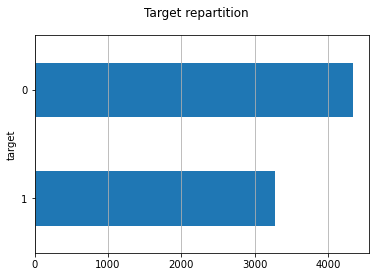

In [8]:
fig, ax = plt.subplots()
fig.suptitle("Target repartition", fontsize=12)
data_train["target"].reset_index().groupby("target").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

**Well, we don't really have a unbalanced dataset, which is good for us :)**

Word Clouds are fun, little graphs that tell us what words are commonly occurring in a corpus. Generating word clouds for each of the label seems like a good way to explore the most common words in each of the 2 different labels.

In [12]:
corpus_real_disaster = " ".join(tweet for tweet in data_train[data_train.target==1].text)
corpus_not_real_disaster = " ".join(tweet for tweet in data_train[data_train.target==0].text)

In [15]:
# Function to create a word cloud object from the corpus with the color map as passed
def generateWordCloud(corpus, cmap):
    """
    Return a Word Cloud object generated from the corpus and color map parameter.
    """
    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

    wordcloud.generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()
    return wordcloud

For the corpus of real disaster, here the top words


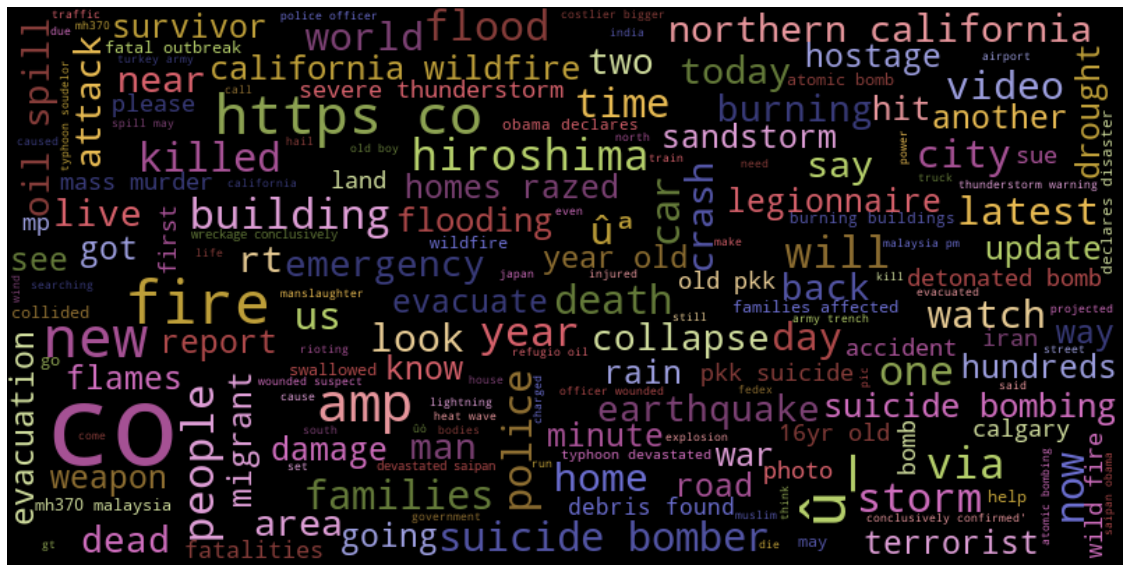

<Figure size 432x288 with 0 Axes>

In [17]:
print('For the corpus of real disaster, here the top words')
generateWordCloud(corpus_real_disaster.lower(), 'tab20b')

**As you can see, many words that appears in the image can be associated with real disaster (storm, damage, suicide bomber, terrorist, hiroshima ...)**

For the corpus of no real disaster, here the top words


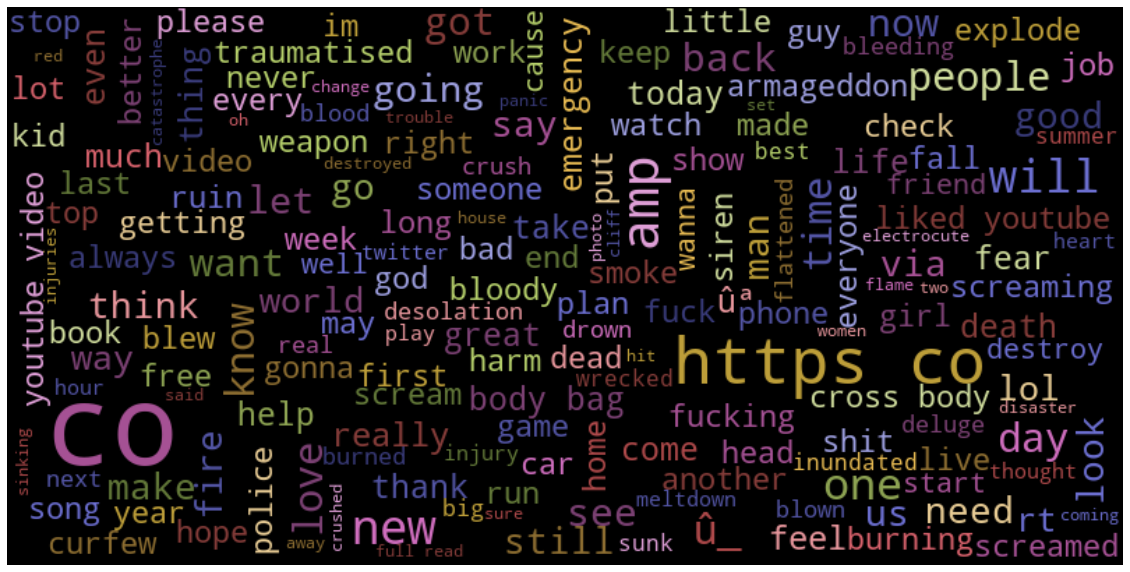

<Figure size 432x288 with 0 Axes>

In [18]:
print('For the corpus of no real disaster, here the top words')
generateWordCloud(corpus_not_real_disaster.lower(), 'tab20b')

**We have few words that can be associated to real disaster (traumatised, explode ..).
That's why I think that we can solve this challenge with bag of words before going further (word embedding, BERT ...)**

# Bag-Of-Words (With TF IDF)

## Preprocessing

Before building the models, I am going to do a preprocessing by cleaning text, removing stop words, and applying lemmatization. This is the classical preprocessing that we do when we deal with nlp tasks.
If you are interested in a deeper text analysis and preprocessing, you can check this article : https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

In [6]:
def utils_preprocess_text(text, do_stemm=False, do_lemm=True, stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if do_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if do_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
# import the list of stopwords from NLTK
lst_stopwords = nltk.corpus.stopwords.words("english")

# Apply the preprocessing
data_train["text_clean"] = data_train["text"].apply(lambda x: 
          utils_preprocess_text(x, do_stemm=False, do_lemm=True, 
          stopwords=lst_stopwords))
data_train.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [8]:
# Im going to split the data_train in two train & val set
# split dataset
XY_train, XY_test = model_selection.train_test_split(data_train, test_size=0.2, random_state=33)

# get target
y_train = XY_train["target"].values
y_test = XY_test["target"].values

# get text
x_train = XY_train["text_clean"]
x_test = XY_test["text_clean"]

## Vectorization

I am going to use the Tf-Idf vectorizer with a limit of 3000 words, with unigrams (which means, for sentence like "I like you" => "I" , "like", "you") and bigrams (we get "I like", "like you")

Text(0.5, 1.0, 'Sparse Matrix Sample')

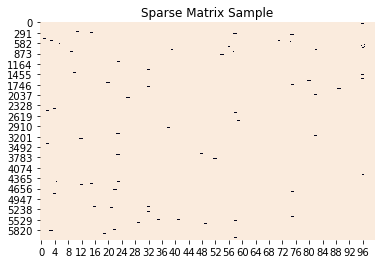

In [33]:
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
dic_vocabulary = vectorizer.vocabulary_
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

Non-zeros values are in black, and as you can see it's pretty sparse.
Then I'm going to make some feature selection.

I will perform a Chi-Square test to determine whether a feature and the  target are independent;
and keep only the features with a certain p-value from the Chi-Square test.

In [55]:
y = XY_train["target"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.70
data_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    data_features = data_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    data_features = data_features.sort_values(["y","score"], 
                    ascending=[True,False])
    data_features = data_features[data_features["score"]>p_value_limit]
X_names = data_features["feature"].unique().tolist()

In [56]:
print(f"Now we have only {len(X_names)} word for the vocabulary")

Now we have only 1494 word for the vocabulary


Text(0.5, 1.0, 'Sparse Matrix Sample')

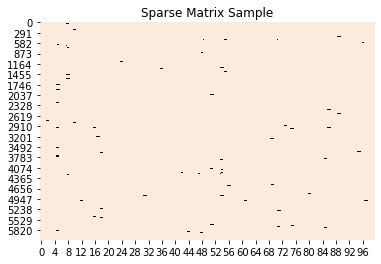

In [57]:
vectorizer_custom = TfidfVectorizer(vocabulary=X_names)
vectorizer_custom.fit(x_train)
X_train_custom = vectorizer_custom.transform(x_train)
dic_vocabulary = vectorizer_custom.vocabulary_
sns.heatmap(X_train_custom.todense()[:,np.random.randint(0,X_train_custom.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

## Models

I will use a Naive Bayes algorithm: a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related.

In [82]:
classifier = naive_bayes.MultinomialNB()

**I will begin with no custom vectorizer (the one that have 3000 words in vocabulary) and I'm going to compare it with the custom one** 

In [83]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = x_test.values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.81
Auc: 0.85
Detail:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       860
           1       0.87      0.66      0.75       663

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.82      0.81      0.80      1523



(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

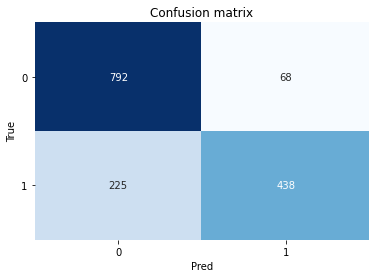

In [84]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

 The BoW achieve an accuracy of 81% but struggle to predict the disaster tweets (225 were classified as no disaster ..)

Let's try with the custom vectorizer

In [66]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer_custom),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_custom, y_train)

## test
X_test = x_test.values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.8
Auc: 0.85
Detail:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       860
           1       0.82      0.71      0.76       663

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.80      0.80      1523



(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

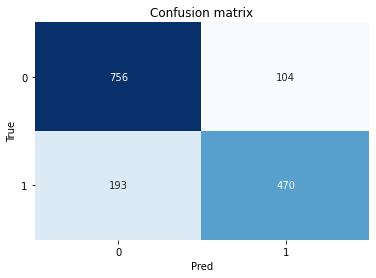

In [77]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

Well they share the same metrics, which shows that feature_selection is not always useful ...

## KAGGLE Submissions with Bag-Of-Words (tf-idf) method 

In [78]:
## Apply preprocessing
data_test["text_clean"] = data_test["text"].apply(lambda x: 
          utils_preprocess_text(x, do_stemm=False, do_lemm=True, 
          stopwords=lst_stopwords))
data_test.head()

,id,text,text_clean
0,0,Just happened a terrible car crash,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [85]:
predicted_test = model.predict(data_test["text_clean"].values)

In [87]:
data_test['target'] = predicted_test

In [89]:
data_to_csv = data_test.drop(['text', 'text_clean'], axis=1)
data_to_csv.to_csv('sample_submissions.csv',index=False)

**The score is 0.79160, which is not bad for a "baseline", Now we are going to focus on more sophisticated techniques**

# Word Embedding (GloVe) + BiLSTM

We will use Keras library to build a recurrent neural network based on bidirectional LSTMs.

You can learn more about LSTM here  : https://colah.github.io/posts/2015-08-Understanding-LSTMs/

This model takes word embeddings as input so we will use pre-trained GloVe embeddings to make the embedding dictionary.

I have downloaded the twitter pre-trained word vectors (https://nlp.stanford.edu/projects/glove/) since we are analysing tweets. It's a 1.42 GB file.

In [18]:
len_sentences = np.array([len(x) for x in data_train["text_clean"].apply(lambda y : y.split())])
print(f"Max Sequence Length is {len_sentences.max()}")

Max Sequence Length is 25


**As you can see, in text_clean, there is 25 tokens max.**

In [19]:
corpus_total = list(set(" ".join(tweet for tweet in data_train.text_clean).split()))
print(f"Max number words is {len(corpus_total)}")

Max number words is 21283


**There is also 21283 differents words**

### Tokenization

In [41]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(np.concatenate((x_train,x_test)))
sequences = tokenizer.texts_to_sequences(np.concatenate((x_train,x_test)))
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 21320


### Padding

In [43]:
x_train_pad = pad_sequences(sequences[:len(x_train)], padding = 'post', maxlen = 50)
x_test_pad = pad_sequences(sequences[len(x_train):], padding = 'post', maxlen = 50)
print('Shape of data tensor:', x_train_pad.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (6090, 50)
Shape of label tensor: (6090,)


In [45]:
embeddings_index = {}
f = open("glove.twitter.27B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Building the Model

In [65]:
# dropout = 0.1 ## OLD
dropout = 0.3
# Initialize the model
input_ = Input(shape=(50), dtype='int32')

# Add embedding layer
x = Embedding(len(word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = 50,
                           trainable=False,
                           name = 'embeddings')

x = x(input_)
# Add hidden layers 
# Add a bidirectional lstm layer
x = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2))(x)
# Add a dropout layer 
x = Dropout(dropout)(x)
# Add a second bidirectional lstm layer
x = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2))(x)
# Add a dropout layer 
x = Dropout(dropout)(x)

# Add a Global Max Pooling layer to  reshape the 3D tensor into a 2D one.
x = GlobalMaxPool1D()(x)

# Add the fully connected layer with 256 nurons and relu activation
x = Dense(256, activation='relu')(x)

x = Dropout(dropout)(x)

# Add the output layer with sigmoid activation since we have 2 classes
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(input_, output_layer)
# Compile the model using sparse_categorical_crossentropy
model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [51]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [60]:
history = model.fit(x_train_pad, y_train, epochs = 5,
                    batch_size=32, validation_data=(x_test_pad, y_test)) ## OLD

Epoch 1/5
191/191 [==============================] - 16s 85ms/step - loss: 0.5089 - accuracy: 0.7470 - val_loss: 0.4662 - val_accuracy: 0.7938
Epoch 2/5
191/191 [==============================] - 16s 84ms/step - loss: 0.4320 - accuracy: 0.8110 - val_loss: 0.4549 - val_accuracy: 0.8056
Epoch 3/5
191/191 [==============================] - 16s 85ms/step - loss: 0.4096 - accuracy: 0.8174 - val_loss: 0.4649 - val_accuracy: 0.7840
Epoch 4/5
191/191 [==============================] - 16s 85ms/step - loss: 0.3918 - accuracy: 0.8291 - val_loss: 0.4452 - val_accuracy: 0.8102
Epoch 5/5
191/191 [==============================] - 16s 86ms/step - loss: 0.3666 - accuracy: 0.8442 - val_loss: 0.4774 - val_accuracy: 0.7820


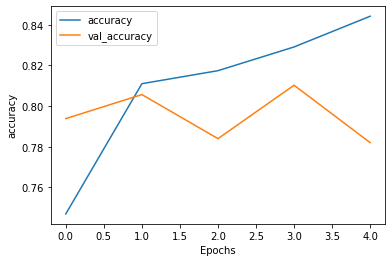

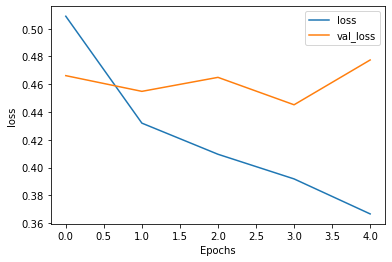

In [61]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

As the training loss is decreasing, the val loss is increasing (same for accuracy) which shows that there is somehow an overfitting

**I will try to increase the value of the dropout, and decrease the batch size.**

In [63]:
history = model.fit(x_train_pad, y_train, epochs = 5,
                    batch_size=16, validation_data=(x_test_pad, y_test))

Epoch 1/5
381/381 [==============================] - 32s 84ms/step - loss: 0.5045 - accuracy: 0.7629 - val_loss: 0.4653 - val_accuracy: 0.7965
Epoch 2/5
381/381 [==============================] - 32s 85ms/step - loss: 0.4338 - accuracy: 0.8122 - val_loss: 0.4668 - val_accuracy: 0.7997
Epoch 3/5
381/381 [==============================] - 32s 84ms/step - loss: 0.4095 - accuracy: 0.8255 - val_loss: 0.4463 - val_accuracy: 0.8089
Epoch 4/5
381/381 [==============================] - 32s 83ms/step - loss: 0.3810 - accuracy: 0.8371 - val_loss: 0.4502 - val_accuracy: 0.8070
Epoch 5/5
381/381 [==============================] - 31s 82ms/step - loss: 0.3623 - accuracy: 0.8486 - val_loss: 0.4728 - val_accuracy: 0.7833


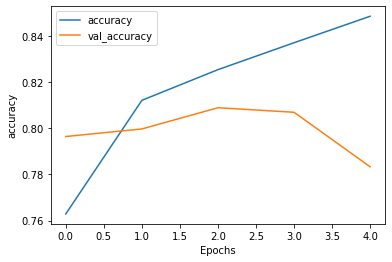

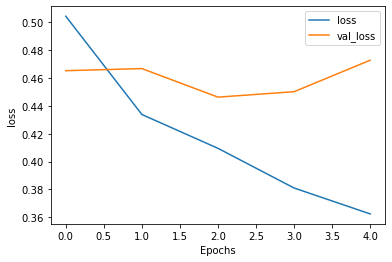

In [64]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Okay, it didn't change anything, but we can notice that after the second epoch he is clearly overfitting. I will stop at two epochs

In [66]:
history = model.fit(x_train_pad, y_train, epochs = 2,
                    batch_size=16, validation_data=(x_test_pad, y_test))

Epoch 1/2
381/381 [==============================] - 31s 81ms/step - loss: 0.4963 - accuracy: 0.7668 - val_loss: 0.4833 - val_accuracy: 0.7807
Epoch 2/2
381/381 [==============================] - 32s 85ms/step - loss: 0.4297 - accuracy: 0.8125 - val_loss: 0.4688 - val_accuracy: 0.7932


In [76]:
print("\n Evaluating Model ... \n")
predicted = model.predict(x_test_pad)
predicted[predicted>=0.5] = 1
predicted[predicted<0.5] = 0
print(metrics.classification_report(y_test, predicted))
print("\n")


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       847
           1       0.80      0.71      0.75       676

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523





# Kaggle Submissions with Glove + BiLSTM

In [79]:
sequences_test = tokenizer.texts_to_sequences(data_test['text_clean'])
x_test_pad_for_kaggle = pad_sequences(sequences_test, padding = 'post', maxlen = 50)

In [83]:
predicted_for_kaggle = model.predict(x_test_pad_for_kaggle)
predicted_for_kaggle[predicted_for_kaggle>=0.5] = int(1)
predicted_for_kaggle[predicted_for_kaggle<0.5] = int(0)

In [86]:
data_test['target'] = predicted_for_kaggle.astype(int)
data_test.head()

,id,text,text_clean,target
0,0,Just happened a terrible car crash,happened terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...,1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,1


In [87]:
data_to_csv = data_test.drop(['text', 'text_clean'], axis=1)
data_to_csv.to_csv('sample_submissions_glove.csv',index=False)

**The score is 0.79681, which is slightly better than the bag-of-words technique ...
I just want to point out that sometimes using "big" techniques doesn't always fix the problem**